In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"#"last_expr_or_assign"

import numpy as np
import matplotlib.pyplot as plt
from util.logger import EventTracker
from util.basis_scaled import *
from util.plot_tools import *
from boundary_solvers.gauss_grid_2d import StokesDirichletProblem
from scipy.io import loadmat
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from hmm.stokes import *
from hmm.stokes_deep import DeepMicroSolver, get_net
import matplotlib

matplotlib.rcParams['text.usetex'] = True

pretty_pyplot_layout()

## Multiscale Problem

We define a multiscale problem as follows. The PDE is a non-slip zero forcing Stokes flow Problem

\begin{equation}
\Delta u  - \nabla p = 0, \qquad \qquad \nabla \cdot u = 0   \qquad \text{inside}\quad \Omega
\end{equation}

with the boundary conditions

\begin{equation}
u = g,\qquad \text{on}\quad\partial\Omega
\end{equation}

the boundary is a two-dimensional pipe with corners at (0,-1) and (1,1), and a micro scale boundary.

## Invariance to boundary conditions
From a physical point of view one can argue that the slip amount corresponds to an equivalent offset of the boundary in the normal direction.
This is easily seen in the special case of couette/shear driven flow, where the horizontal component of the velocity field is a linear interpolation between the upper boundary and an imaginary boundary, offset by $\alpha$:
$$
    u(y) = \frac{y + \alpha}{1 + \alpha}U.
$$
Extrapolating from this toy example, we conjecture that a reasonable property of the slip amound is invariance to flow constraints in the interior domain, such as dirichlet boundary conditions and pressure gradients.


In [2]:
i = 41#34 #41 # 38 #41 #35 #11 #38 #22 
data, info = StokesData.load_from_matlab(f"/home/emastr/phd/data/reference_2/run_{i}.mat")
data_big_domain = data
dom = data.dom
eval_pos = info["eval_pos"]
eps = info["eps"]
nper = info["nper"]
Lx = info["Lx"]
bbox = info["bbox"]
Uc = info['Uc']
Vc = info['Vc']
Uyc = info['Uyc']

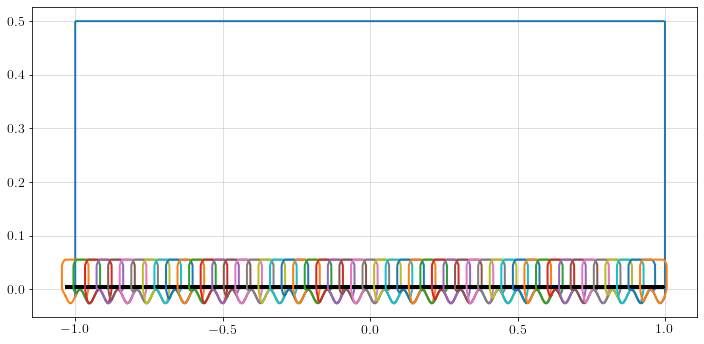

In [3]:
logger = EventTracker() # Log time

tol = 1e-10
#################
# Macro problem
#################

xDim = 21
yDim = 21
macro = StokesMacProb(data, lambda x,a: fft_interp(x, a, dom=dom[0], dim=11))
###################
# Micro problems
###################

nMic = 51 #freq_g*2+1#2*(round(Lx/(30*eps)) // 2) + 1 # 15 # 15 #nMic*2 +1
yDim_reduce=13
xDim_reduce=13
width= 5*eps #5*eps #3
height=width*0.8 #3
n_refine=0
#xPos = np.linspace(dom[0][0]+4*eps, dom[0][1]-4*eps, nMic)-2*eps
xPos = np.linspace(dom[0][0], dom[0][1], nMic+1)[1:] - width/2 - Lx / nMic/1
micros = [StokesMicProb(data, x, width, height, linePos=0.0, deg_project=8, logger=logger, 
                        n_refine=n_refine, xDim_reduce=xDim_reduce, yDim_reduce=yDim_reduce) for x in xPos]

###################
# Hmm problem.
conv_checker = ConvergenceChecker(macro, micros, tol=tol)
hmm_prob = StokesHMMProblem(macro, micros, data, convergence_checker=conv_checker)

hmm_prob.plot(plt.gca())


In [4]:
class Callback():
    def __init__(self, macro):
        self.N = 100
        self.x = np.linspace(0,1,self.N)
        self.macro = macro
        self.current_alpha = macro.alpha(self.x)
        self.diff = []
    
    def __call__(self, it, macro_sol, micro_sols):
        self.previous_alpha = self.current_alpha
        self.current_alpha = self.macro.alpha(self.x)
        self.diff.append(np.linalg.norm(self.previous_alpha - self.current_alpha) / self.N**0.5)
        

Precomputing...
Done
HMM Solver...
Convergence (not necessarily to solution) at step 12/20

Done
Precomputing...
Done
HMM Solver...


/home/emastr/phd/util/basis_scaled.py:416: RuntimeWarning: invalid value encountered in multiply
  return ifft(ifftshift(coef)) * len(coef)
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in cdouble_scalars
  c1 = tmp + c1*x2
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in cdouble_scalars
  c1 = tmp + c1*x2
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in cdouble_scalars
  return c0 + c1*x
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/numpy/polynomial/chebyshev.py:1173: RuntimeWarning: overflow encountered in cdouble_scalars
  c0 = c[-i] - c1
/home/emastr/phd/util/basis_scaled.py:402: RuntimeWarning: overflow encountered in add
  y += coef[i] * np.exp(freq[i] * x)
/home/emastr/anaconda3/envs

/home/emastr/phd/boundary_solvers/geometry.py:1287: RuntimeWarning: invalid value encountered in multiply
  return self.inner(1j * v, f)
/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Step 19/20
Done
Precomputing...
Done
HMM Solver...


/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Step 19/20
Done
Precomputing...
Done
HMM Solver...


/home/emastr/anaconda3/envs/pimlenv/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Step 19/20
Done


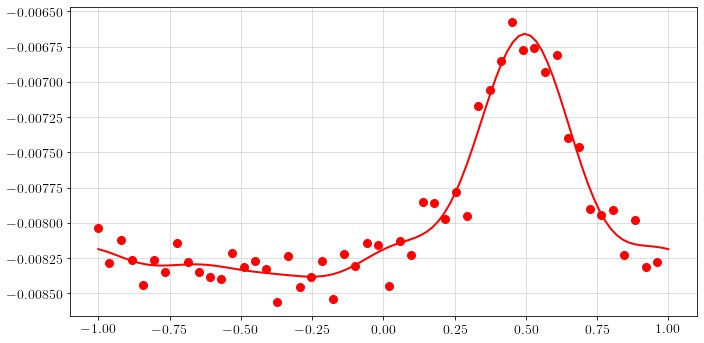

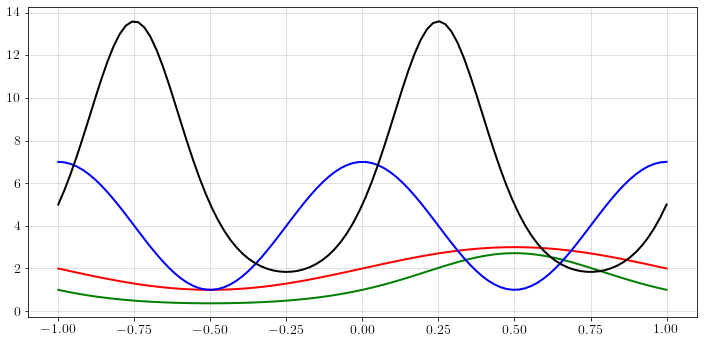

In [5]:
gs = [lambda x: 2 + np.sin(np.pi*x),
      lambda x: np.exp(np.sin(np.pi*x)),
      lambda x: 4 + 3 * np.cos(2*np.pi*x),
      lambda x: 5 * np.exp(np.sin(2*np.pi*x)),
]

cols = ['r', 'g', 'b', 'k']

for g_cond, col in zip(gs, cols):
    data.g = g_cond
    
    debug_cb = Callback(macro)

    print("Precomputing...")
    macro_solver = MacroSolver(xDim, yDim)
    micro_solvers = [MicroSolver(m) for m in micros]
    hmm_solver = IterativeHMMSolver(macro_solver, micro_solvers)
    print("Done")
    
    print("HMM Solver...")
    macro_guess = macro_solver.solve(macro)
    (macro_sol, micro_sols) = hmm_solver.solve(hmm_prob, macro_guess=macro_guess, 
                                            callback=debug_cb, verbose=True, maxiter=20)
    print("\nDone")

    x = np.linspace(-1,1,100)
    
    plt.figure(1)
    a = macro.alpha(x)
    plt.plot(x, a.real, color=col)
    plt.plot([m.x for m in micro_sols], [m.alpha for m in micro_sols], 'o', color=col)
    
    plt.figure(2)
    plt.plot(x, g_cond(x), color=col)